# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Forecasting Bike Sharing Usage



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here: 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

/Users/krader/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1 [10pts]: Data Read-In and Cleaning </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

#### **1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

In [4]:
# your code here
bikes_df = pd.read_csv('data/BSS_hour_raw.csv')
print(bikes_df.info())
bikes_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
dteday        17379 non-null object
season        17379 non-null int64
hour          17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weather       17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 1.7+ MB
None


,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [5]:
# your code here
bikes_df.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [6]:
# your code here
bikes_df.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

*Your answer here*

The temperature(`temp`), average temperature (`atemp`)	humidity (`hum`), and windspeed (`winspeed`) variables seem to have been normalized to range from 0 to 1. If not, for instance, DC would see high of 1 degrees and a low of 0.2 degrees farenheight.

All data types make sense for the data stored, except dteday, which is an object.


#### **1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

In [7]:
# your code here
bikes_df['dteday'] = pd.to_datetime(bikes_df['dteday'])
bikes_df.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

#### **1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that hour (this is the response variable for later).

In [8]:
# your code here

# function to assign 0 to 2011 and 1 to 2012
def encode_year(x):
    return np.int64(np.floor(x-2011))
   
    
# create `year` column
bikes_df.loc[:,'year'] = bikes_df.dteday.dt.year

# create `month` column
bikes_df.loc[:,'month'] = bikes_df.dteday.dt.month
   
# encode `year` column with 0 and 1
bikes_df['year'] = bikes_df['year'].apply(encode_year)

bikes_df['counts'] = bikes_df.casual+ bikes_df.registered

# re-organize the columns 
columns = ['dteday','hour','season', 'holiday', 'year','month','weekday', \
           'workingday','weather', 'temp', 'atemp', 'hum', 'windspeed', \
           'casual', 'registered', 'counts']
bikes_df = bikes_df.reindex(columns = columns)

In [9]:
# your code here

bikes_df.head()

,dteday,hour,season,holiday,year,month,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,counts
0,2011-01-01,0,1,0,0,1,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,1,0,0,1,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,2,1,0,0,1,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,3,1,0,0,1,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,4,1,0,0,1,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question, we continue validating the data, and begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

**2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

**2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 



### Answers

#### **2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

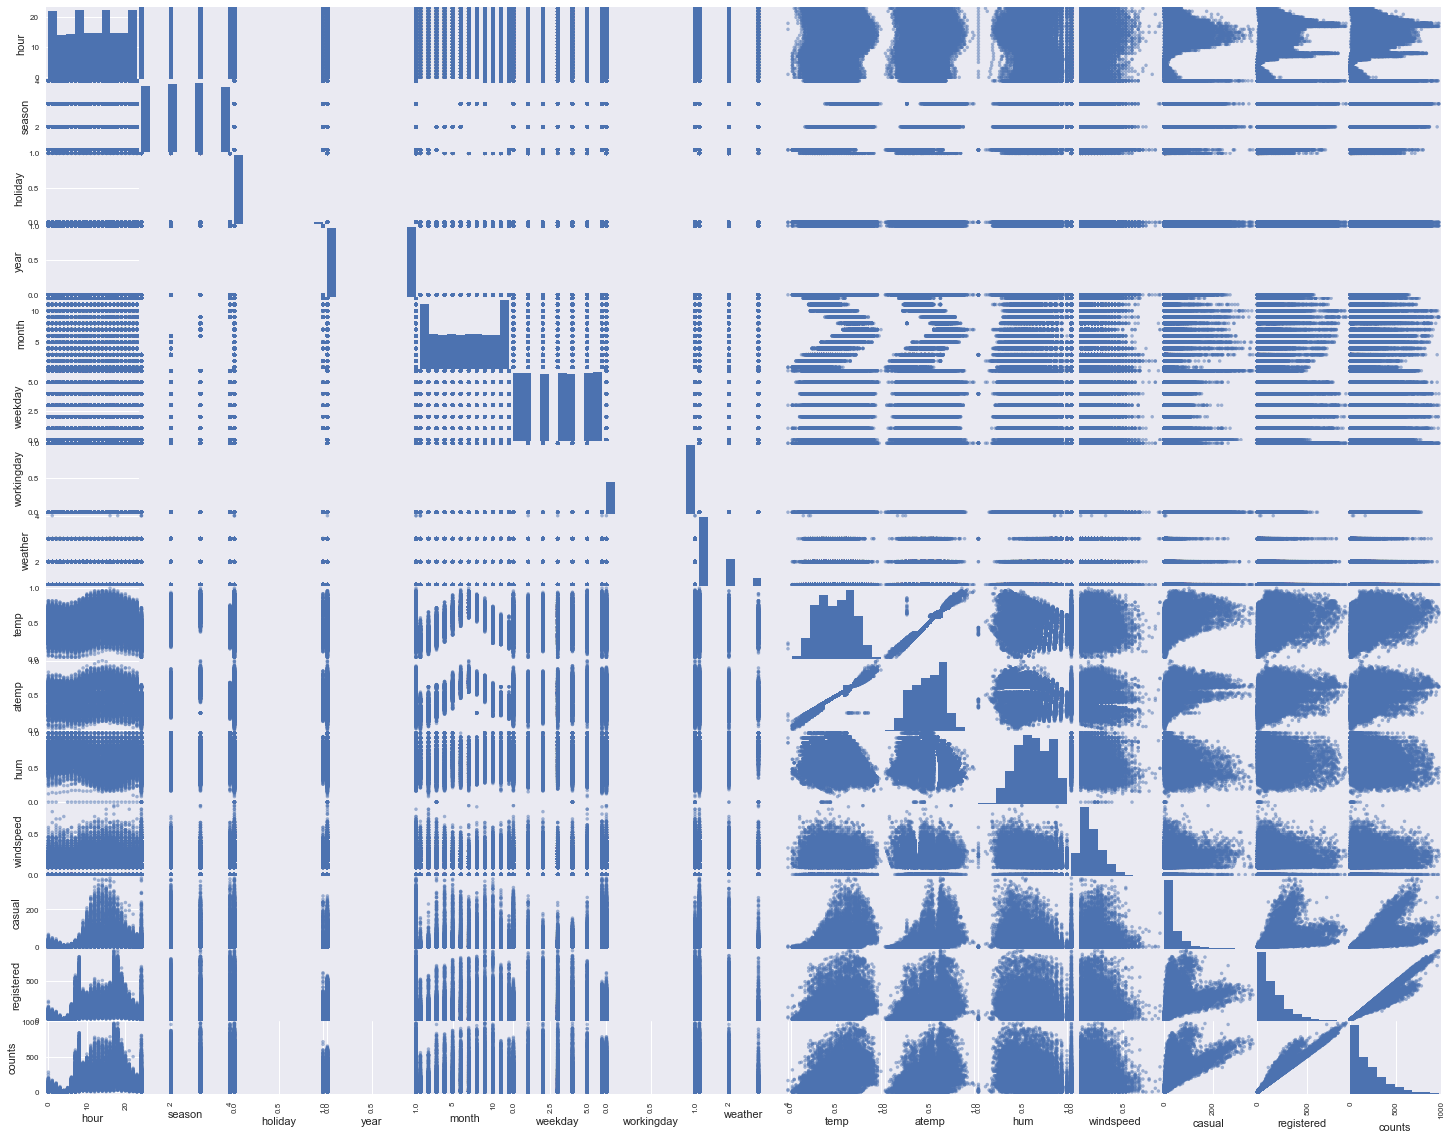

In [10]:
# your code here

# make combinations of features
scatter_matrix(bikes_df, alpha=0.5, figsize=(25,20));


*your answer here* 

Strongly related variables: temp and atemp, registered and counts, casual and counts, casual and registered. Less significant correlation between temp and casual, and atemp and casual.

#### **2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

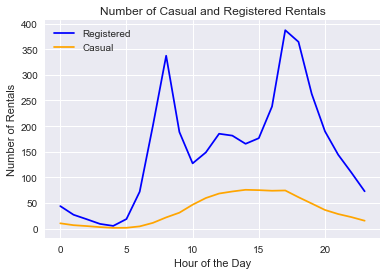

In [11]:
# your code here
reg_color = 'blue'
casual_color = 'orange'

mean_data = bikes_df.groupby('hour').aggregate({'casual': np.mean, 'registered': np.mean})

num_days = mean_data.shape[0]
plt.plot(np.arange(num_days), mean_data['registered'], color = reg_color, label="Registered")
plt.plot(np.arange(num_days), mean_data['casual'], color = casual_color, label="Casual")

plt.xlabel("Hour of the Day")
plt.ylabel("Number of Rentals")
plt.title("Number of Casual and Registered Rentals")
plt.legend();

*your answer here*

Trends: It appears that the number of registered users is higher than the number of casual users at peak hours of the day (i.e. rush hour at 8am and 5pm, approximately). There is more fluctuation in the number of registered users throughout the day than in the number of casual users.

#### **2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

In [12]:
# your code here

days_tick_dict = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday',
                 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}  

hours_tick_dict = {k:v for k,v in zip(range(24),range(24))}
def get_violin_lists(bikes_data, colname):
    """Helper function for building violin plots."""
    
    # prepare the lists
    reg_data = []
    cas_data = []
    
    # at each day, record ALL values of 'rigistered' and 'casual' observed    
    for cur_val, cur_df in bikes_data.groupby(colname):
        cur_registered = cur_df['registered'].copy().values.reshape(-1,1)
        cur_casual = cur_df['casual'].copy().values.reshape(-1,1)

        reg_data.append(cur_registered)
        cas_data.append(cur_casual)
    
    # return the lists
    return reg_data,cas_data


# color the registered users orange
def color_violin(violin_result, color_string):
    """Helper to color a violin plot"""
  
    # color the distribution
    for pc in violin_result['bodies']:
        pc.set_color(color_string)

    # color the lines
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin_result[partname]
        vp.set_edgecolor(color_string)

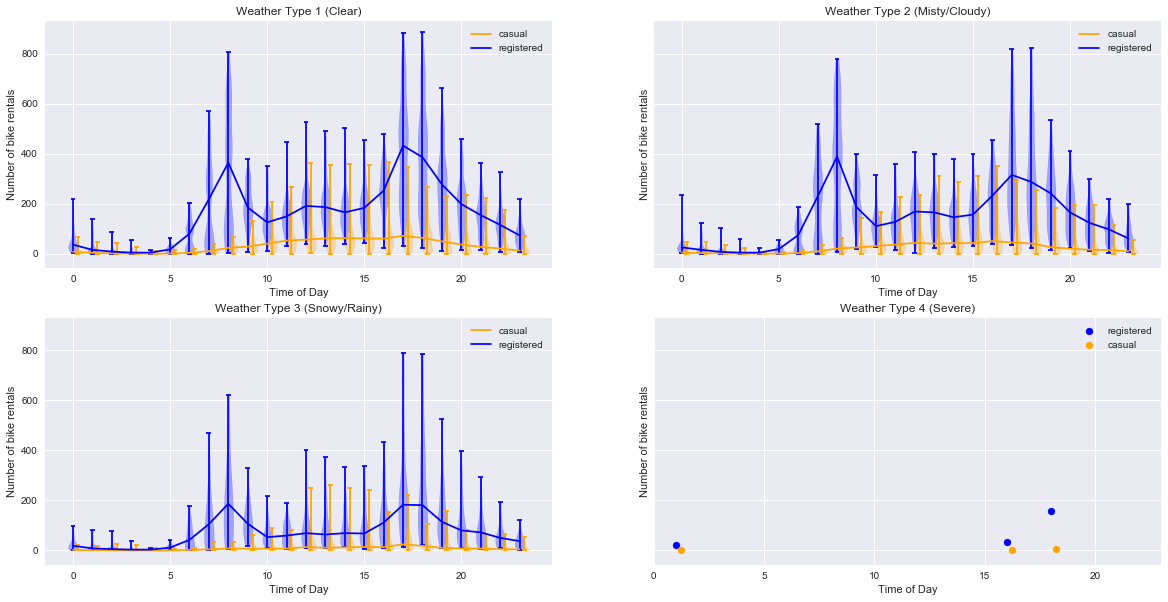

In [13]:
# your code here

fig, ax = plt.subplots(2,2, figsize=(20,10), sharey=True)
ax = ax.ravel()

weather_strings = ["Clear", "Misty/Cloudy", "Snowy/Rainy", "Severe"]
for cur_weather in range(1,5):
    cur_ax = ax[cur_weather-1]
    cur_weather_string = weather_strings[cur_weather-1]
    
    bikes_df_weather = bikes_df[(bikes_df.weather == cur_weather)]
    
    
    if cur_weather == 4:
        # for blizard weather we have maximum one data point per hour, and often none
        # just scatter plot the data
        reg = cur_ax.scatter(bikes_df_weather['hour'].values, bikes_df_weather['registered'].values, color = reg_color, label="registered")
        cas = cur_ax.scatter(bikes_df_weather['hour'].values+.25, bikes_df_weather['casual'].values, color = casual_color, label="casual")
    else:
        #for most weathers, we just plot the mean at each hour
        mean_data = bikes_df_weather.groupby('hour').aggregate({'casual': np.mean, 'registered': np.mean})
        # mean lines
        reg_hourly_data_mean= mean_data['registered']
        cas_hourly_data_mean= mean_data['casual']
        
        cur_ax.plot(cas_hourly_data_mean, casual_color, label="casual")
        cur_ax.plot(reg_hourly_data_mean, reg_color, label="registered")
        
    cur_ax.legend()
    
    cur_ax.set_xticks(list(hours_tick_dict.keys()), list(hours_tick_dict.values()))
    cur_ax.set_ylabel('Mean Number of Bike Rentals')
    cur_ax.set_xlabel('Time of Day')
    cur_ax.set_title('Weather Type {} ({})'.format(cur_weather, cur_weather_string))

*your answer here*

It seems that the weather does not have a significant impact on the number of riders (both casual and registered) which is contraintuitive. However, in the severe weather conditions, almost no rides take place as one would expect.  Note: the violin plots were not expected (only the line grphs in each subplot would suffice), but they definitely add to the story.


#### **2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

#### Name this dataframe `bikes_by_day`.

#### Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

In [14]:
# your code here

bikes_by_day = bikes_df.copy()
# for scatterplot of season against counts first we need to group by day and 
# aggregate counts
bikes_by_day = bikes_by_day[['dteday', 'weather', 
                             'season', 'windspeed', 'temp', 'atemp', 
                             'hum', 
                             'weekday', 'casual', 'registered', 
                             'counts']].groupby('dteday').agg({'counts' : np.sum,
                                                                'casual' : np.sum,
                                                                'weather': np.max,
                                                                'registered' : np.sum,
                                                                'season' : np.mean,
                                                                'weekday' : np.mean,
                                                                'windspeed': np.mean,
                                                                'temp' : np.mean,
                                                                'atemp' : np.mean,
                                                                'hum' : np.mean})
bikes_by_day.head(5)

,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum
dteday,,,,,,,,,,
2011-01-01,985,331,3,654,1,6,0.160446,0.344167,0.363625,0.805833
2011-01-02,801,131,3,670,1,0,0.248539,0.363478,0.353739,0.696087
2011-01-03,1349,120,1,1229,1,1,0.248309,0.196364,0.189405,0.437273
2011-01-04,1562,108,2,1454,1,2,0.160296,0.200000,0.212122,0.590435
2011-01-05,1600,82,1,1518,1,3,0.186900,0.226957,0.229270,0.436957


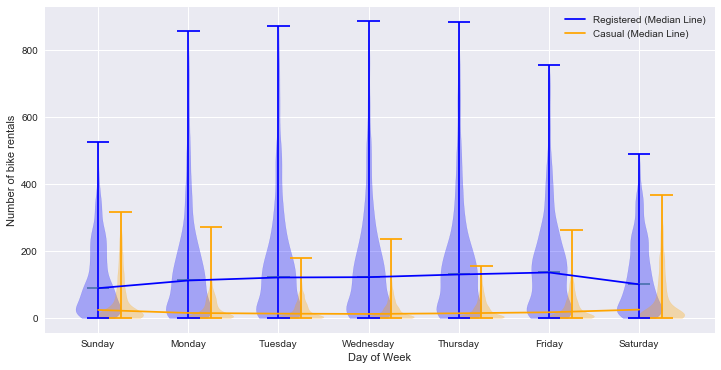

In [15]:
# your code here

# get data for the violin plot
reg_data,cas_data = get_violin_lists(bikes_df, 'weekday')

# plot the violins
plt.figure(figsize=(12,6))
plt.xticks(list(days_tick_dict.keys()), list(days_tick_dict.values()))
position_array = np.arange(len(reg_data))
reg = plt.violinplot(dataset=reg_data, positions=position_array, showmedians=True, showextrema=True)
cas = plt.violinplot(dataset=cas_data, positions=position_array+.25)

# color the violins
color_violin(reg, reg_color)
color_violin(cas, casual_color)

# calculate the median number of registered/casual riders on each weekday
mids = bikes_df.groupby("weekday").median()[["registered","casual"]]

# plot a line connecting the medians of each ditribution
med = plt.plot(position_array, mids["registered"].values,c = reg_color, label="Registered (Median Line)")
medb = plt.plot(position_array, mids["casual"].values,c=casual_color, label="Casual (Median Line)")

# labels
plt.ylabel('Number of bike rentals')
plt.xlabel('Day of Week')
plt.legend()

plt.show()

*your answer here*

Registered: We can see that there is clearly more rides during weekdays than on the weekends. We can hypothesize that registered riders use the bikes to ride to work.
Casual: On the flip side, the casual riders are clearly utilizing the bikes more on the weekends, perhaps for casually riding around the city and less so for work commute.  Note: boxplot would more than suffice to answer this question.


#### **2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

In [16]:
# your code here 
data = [sorted(np.random.normal(0, std, 100)) for std in range(1, 5)]


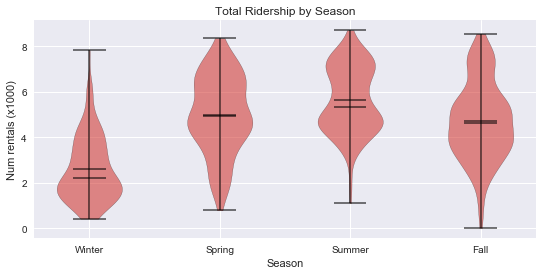

In [17]:
# your code here

# make a figure with two plots
fig, ax1 = plt.subplots(figsize=(9, 4), sharey=True)

for i in range(1,5):
    parts = ax1.violinplot(bikes_by_day.loc[bikes_by_day.season==i,'counts']/1000, positions=[i], 
                  showmeans=True, showmedians=True, showextrema=True)
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(.6)
        
    # color the lines
    for partname in ('cbars','cmins','cmaxes', 'cmedians', 'cmeans'):
        vp = parts[partname]
        vp.set_edgecolor('black')
        vp.set_alpha(0.6)


    
    
labels = ["Winter", "Spring", "Summer", "Fall"]
ax1.set_title('Total Ridership by Season')
ax1.set_xlabel("Season")
ax1.set_xticks(np.arange(1, 5))
ax1.set_xticklabels(labels)
ax1.set_ylabel("Num rentals (x1000)");

Or, more simply:

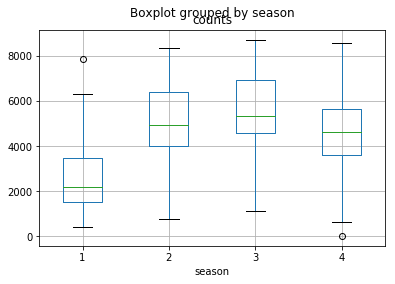

In [16]:
bikes_by_day.boxplot('counts',by='season');

In [85]:
# your code here

# find outlier of variable var_of_interest for season s
def find_outlier(s, var_of_interest, data):
    #print(s)
    pass
    season_df = data[data.season == s]
    
    raw_data = season_df.loc[:,var_of_interest]
    q1 = np.percentile(raw_data,25)
    q3 = np.percentile(raw_data,75)
    IQR = q3 - q1
    
    #print(q1, IQR)
    upper_bound = q3 + 1.5*IQR 
    lower_bound = q1 - 1.5*IQR 
    
    outliers_flag = np.logical_or(raw_data>upper_bound, raw_data<lower_bound)
    
    if np.sum(outliers_flag) == 0:
        print ('no outliers found')
        return None
    else:
        print(np.sum(outliers_flag),"outlier(s) found")
        return season_df.loc[outliers_flag]
    

In [86]:
# your code here 

df = pd.DataFrame(columns = bikes_by_day.columns)

# find outliers in each season
for cur_season in [1,2,3,4]:
    print("Season {}".format(cur_season))
    df = df.append(find_outlier(cur_season, 'counts', bikes_by_day))

df

Season 1
1 outlier(s) found
Season 2
no outliers found
Season 3
no outliers found
Season 4
1 outlier(s) found


,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum
2012-03-17,7836,3155,2,4681,1,6,0.110704,0.514167,0.505046,0.755833
2012-10-29,22,2,3,20,4,1,0.358200,0.440000,0.439400,0.880000


*your answer here* 



We see that the total number of rentals tends to be smaller in the winter (season 1) which makes sense. It then increases in spring, peaks in summer and starts falling again in fall but not as much as in winter.

We observe that March 17, 2012 that is much higher that the others. This is our only high outlier.  It was **St. Patrick's Day** on 2012/3/17! So we concur that this is a real observation (lots of partying!).

And Oct-29-2012, a quick search reveals it was **hurricane Sandy** hitting Washington, DC. Thus, we concur this is a real observation as well (not safe to be biking around that day). 

<HR>

<div class='exercise'> <b> Question 3 [10pts]: Prepare the data for Regression </b> </div>

In order to build and evaluate our regression models, a little data cleaning is needed.  In this problem, we will explicitly create binary variables to represent the categorical predictors, set up the train-test split in a careful way, remove ancillary variables, and do a little data exploration that will be useful to consider in the regression models later.

**3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

**3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. 

**3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.



#### Answers

#### **3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

In [21]:
# your code here
#save the pre-recoding bikes data
bikes_df_raw = bikes_df.copy(deep=True)
bikes_df.head()

,dteday,hour,season,holiday,year,month,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,counts
0,2011-01-01,0,1,0,0,1,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,1,0,0,1,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,2,1,0,0,1,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,3,1,0,0,1,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,4,1,0,0,1,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [22]:
#your code here
categorical_columns = ['season', 'month', 'holiday', 'weekday', 'workingday', 'weather']
categorical_columns_g2cols = ['season', 'month', 'weekday', 'weather']
numerical_columns = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'counts']

bikes_df = pd.get_dummies(bikes_df_raw, columns=categorical_columns_g2cols, drop_first=True)

In [23]:
#your code here
bikes_df.columns

Index(['dteday', 'hour', 'holiday', 'year', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'counts', 'season_2',
       'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

In [24]:
#your code here
# give more meaningful names to the one-hot encoded variables
seasons = {'season_2': 'spring', 'season_3': 'summer', 'season_4': 'fall',}
months = {'month_2': 'Feb', 'month_3': 'Mar', 'month_4': 'Apr',
       'month_5':'May', 'month_6': 'Jun', 'month_7': 'Jul', 'month_8': 'Aug', 'month_9': 'Sept', 'month_10': 'Oct',
       'month_11': 'Nov', 'month_12': 'Dec', }
weekdays = {'weekday_1': 'Mon', 'weekday_2': 'Tue', 'weekday_3': 'Wed',
       'weekday_4': 'Thu', 'weekday_5': 'Fri', 'weekday_6': 'Sat'}
weather = {'weather_2': 'Cloudy', 'weather_3': 'Snow', 'weather_4': 'Storm'}

combined_renamer = {**seasons, **months, **weekdays, **weather}

In [25]:
#your code here
bikes_df = bikes_df.rename(columns=combined_renamer)

In [26]:
#your code here
bikes_df.head()

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,2011-01-01,0,0,0,0,0.24,0.2879,0.81,0.0,3,...,0,0,0,0,0,0,1,0,0,0
1,2011-01-01,1,0,0,0,0.22,0.2727,0.80,0.0,8,...,0,0,0,0,0,0,1,0,0,0
2,2011-01-01,2,0,0,0,0.22,0.2727,0.80,0.0,5,...,0,0,0,0,0,0,1,0,0,0
3,2011-01-01,3,0,0,0,0.24,0.2879,0.75,0.0,3,...,0,0,0,0,0,0,1,0,0,0
4,2011-01-01,4,0,0,0,0.24,0.2879,0.75,0.0,0,...,0,0,0,0,0,0,1,0,0,0


####  **3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm.

In [27]:
# your code here
### split in train and test, keeping equal representation of each on month in train and test
bikes_train, bikes_test = train_test_split(bikes_df, test_size=.2, stratify=bikes_df_raw['month'])

In [28]:
# your code here
bikes_train.head()

dteday  hour  holiday  year  workingday  temp   atemp   hum  \
4946  2011-07-30     0        0     0           0  0.76  0.6970  0.55   
8598  2011-12-30     1        0     0           1  0.26  0.2879  0.65   
17118 2012-12-21     1        0     1           1  0.44  0.4394  0.88   
3285  2011-05-21    19        0     0           0  0.68  0.6364  0.47   
10571 2012-03-21    14        0     1           1  0.56  0.5303  0.78   

       windspeed  casual  ...    Dec  Mon  Tue  Wed  Thu  Fri  Sat  Cloudy  \
4946      0.1940      60  ...      0    0    0    0    0    0    1       0   
8598      0.0896       9  ...      1    0    0    0    0    1    0       0   
17118     0.3881       2  ...      1    0    0    0    0    1    0       0   
3285      0.1642     117  ...      0    0    0    0    0    0    1       0   
10571     0.0000      74  ...      0    0    0    1    0    0    0       1   

       Snow  Storm  
4946      0      0  
8598      0      0  
17118     1      0  
3285      0      0  
10571     0      0  

[5 rows x 35 columns]

In [29]:
# your code here
bikes_test.head()

dteday  hour  holiday  year  workingday  temp   atemp   hum  \
15975 2012-11-03     8        0     1           0  0.34  0.3030  0.46   
17249 2012-12-26    14        0     1           1  0.22  0.2121  0.93   
1608  2011-03-12    12        0     0           0  0.34  0.3182  0.53   
4438  2011-07-08    20        0     0           1  0.66  0.6061  0.83   
4676  2011-07-18    18        0     0           1  0.82  0.7727  0.49   

       windspeed  casual  ...    Dec  Mon  Tue  Wed  Thu  Fri  Sat  Cloudy  \
15975     0.2985      10  ...      0    0    0    0    0    0    1       1   
17249     0.2537       0  ...      1    0    0    1    0    0    0       0   
1608      0.2836      51  ...      0    0    0    0    0    0    1       0   
4438      0.1642      30  ...      0    0    0    0    0    1    0       0   
4676      0.3582      80  ...      0    1    0    0    0    0    0       0   

       Snow  Storm  
15975     0      0  
17249     1      0  
1608      0      0  
4438      0      0  
4676      0      0  

[5 rows x 35 columns]

*your answer here*

For the splitting algorithm, we use `sklearn`'s `train_test_split` function. This function creates random train and test subsets of the dataset. Additionally, the flag `stratify` ensures that all months are equally represented in each set. 

#### **3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.

In [30]:
# your code here
bikes_train = pd.read_csv('data/BSS_train.csv', index_col=0).reset_index(drop=True)
bikes_train = bikes_train.drop(['dteday','casual','registered'], axis=1)

bikes_test = pd.read_csv('data/BSS_test.csv', index_col=0).reset_index(drop=True)
bikes_test = bikes_test.drop(['dteday','casual','registered'], axis=1)

In [31]:
# your code here
bikes_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,0,0,0,0.24,0.2879,0.81,0.0,16,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0.22,0.2727,0.80,0.0,40,0,...,0,0,0,0,0,0,1,0,0,0
2,2,0,0,0,0.22,0.2727,0.80,0.0,32,0,...,0,0,0,0,0,0,1,0,0,0
3,3,0,0,0,0.24,0.2879,0.75,0.0,13,0,...,0,0,0,0,0,0,1,0,0,0
4,4,0,0,0,0.24,0.2879,0.75,0.0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [32]:
# your code here
bikes_test.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,6,0,0,0,0.22,0.2727,0.80,0.0000,2,0,...,0,0,0,0,0,0,1,0,0,0
1,9,0,0,0,0.32,0.3485,0.76,0.0000,14,0,...,0,0,0,0,0,0,1,0,0,0
2,20,0,0,0,0.40,0.4091,0.87,0.2537,36,0,...,0,0,0,0,0,0,1,1,0,0
3,10,0,0,0,0.36,0.3485,0.81,0.2239,53,0,...,0,0,0,0,0,0,0,1,0,0
4,12,0,0,0,0.36,0.3333,0.66,0.2985,93,0,...,0,0,0,0,0,0,0,1,0,0


<div class='exercise'> <b> Question 4 [20pts]: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

**4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

**4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?


### Answers
#### **4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

In [33]:
# your code here

# multiple linear regression
X_train = sm.add_constant(bikes_train.drop('counts', axis=1))
X_test = sm.add_constant(bikes_test.drop('counts', axis=1))
y_train = bikes_train['counts'].values.reshape(-1,1)
y_test = bikes_test['counts'].values.reshape(-1,1)

model = OLS(y_train, X_train)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     316.8
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        20:15:29   Log-Likelihood:                -88306.
No. Observations:               13903   AIC:                         1.767e+05
Df Residuals:                   13872   BIC:                         1.769e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.0830      8.641     -2.440      0.015     -38.020      -4.146
hour           7.2214      0.184     39.144      0.000       6.860       7.583
holiday      -18.0958      6.597     -2.743      0.006     -31.027      -5.165
year          76.3519      2.380     32.084      0.000      71.687      81.017
workingday    11.3178      2.751      4.114      0.000       5.926      16.710
temp         333.2482     44.162      7.546      0.000     246.684     419.812
atemp         74.6312     46.207      1.615      0.106     -15.940     165.202
hum         -205.4959      7.801    -26.343      0.000    -220.786    -190.205
windspeed     22.5168     10.753      2.094      0.036       1.439      43.595
spring        43.1541      7.417      5.818      0.000      28.615      57.693
summer        29.5426      8.773      3.367      0.001      12.346      46.739
fall          68.5953      7.492      9.156      0.000      53.911      83.280
Feb           -7.6430      5.966     -1.281      0.200     -19.336       4.050
Mar          -11.6737      6.665     -1.752      0.080     -24.737       1.390
Apr          -41.5244      9.878     -4.204      0.000     -60.886     -22.163
May          -33.2927     10.543     -3.158      0.002     -53.958     -12.628
Jun          -65.8039     10.716     -6.141      0.000     -86.809     -44.799
Jul          -93.4805     12.086     -7.734      0.000    -117.171     -69.789
Aug          -59.2081     11.832     -5.004      0.000     -82.401     -36.015
Sept         -16.0517     10.575     -1.518      0.129     -36.780       4.676
Oct          -16.1602      9.865     -1.638      0.101     -35.497       3.177
Nov          -25.8732      9.527     -2.716      0.007     -44.547      -7.199
Dec          -10.2043      7.614     -1.340      0.180     -25.128       4.719
Mon           -2.6601      2.978     -0.893      0.372      -8.498       3.177
Tue           -6.1425      3.208     -1.915      0.056     -12.430       0.145
Wed            2.2964      3.183      0.721      0.471      -3.943       8.536
Thu           -3.1611      3.185     -0.993      0.321      -9.404       3.082
Fri            2.8892      3.186      0.907      0.364      -3.355       9.133
Sat           14.9459      4.382      3.411      0.001       6.357      23.535
Cloudy         6.7868      2.900      2.341      0.019       1.103      12.470
Snow         -28.2859      4.819     -5.870      0.000     -37.731     -18.841
Storm         42.3569     98.377      0.431      0.667    -150.475     235.189
==============================================================================
Omnibus:                     2831.359   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5657.789
Skew:                           1.224   Prob(JB):                         0.00
Ku

In [34]:
# your code here
y_hat_train = results.predict()
y_hat_test = results.predict(exog=X_test)

# calculating and reporting the requested values, particularly the Test R^2
print('Train R^2 = {:.4}'.format(results.rsquared))
print('Test R^2 = {:.4}'.format(r2_score(bikes_test['counts'], y_hat_test)))

Train R^2 = 0.4065
Test R^2 = 0.4064


#### **4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

In [35]:
# your code here
results.params[((results.pvalues < 0.005) & (results.params > 0))]

hour            7.221382
year           76.351903
workingday     11.317765
temp          333.248241
spring         43.154064
summer         29.542551
fall           68.595334
Sat            14.945929
dtype: float64

In [36]:
# your code here
results.params[((results.pvalues < 0.005) & (results.params < 0))]

hum    -205.495864
Apr     -41.524384
May     -33.292706
Jun     -65.803934
Jul     -93.480482
Aug     -59.208113
Snow    -28.285890
dtype: float64

*your answer here*

The statistically significant variables with positive correlation: hour, year, workingday, temp, spring, summer, fall, Sat.

The statistically significant variables with negative correlation: the intercept, hum, Apr, May, Jun, Jul, Aug, Snow.

Most of these variables display a clear connection to factors reasonably believed to influence if someone would go biking, namely, temperature, humidity, weather, time of day, and day of the week.  In some cases, those particular variables are literally in our list of statistically siginificant variables.  In most of the remaining cases, the variable appears to heavily influence the preceding factors. Year is worth noting as a positive correlation.  This indicates that ridership increased from 2011 to 2012, a likely event as the bike program grew.
  
With that said, many values are difficult to interpret, and may be a sign of a weak model. For instance, `Jul` and `Aug` having a negative effect, even factoring `Summer`, is a little odd. Though, it could be that the effect of these months is getting confused with the effects of temperature and humidity.

<HR>

#### **4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

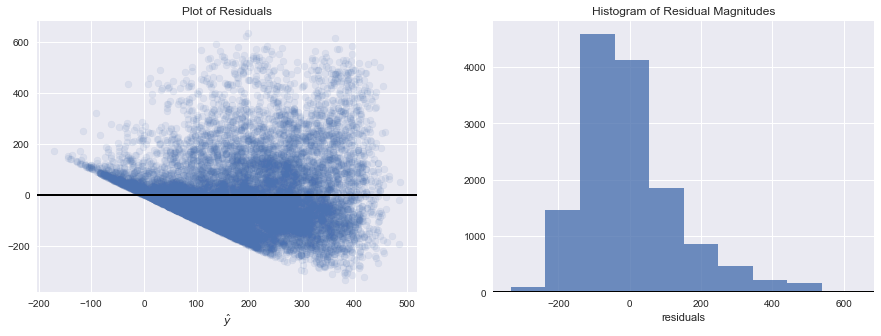

In [38]:
# your code here
residuals = y_train[:,0] - y_hat_train
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_hat_train, residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')

axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()

*your answer here* 

We see that linear regression is a poor model for this data.  In the residual scatterplot on the left, the variance of the residuals increases as y-hat increases, while there is also a pattern to the residuals (not uniform around zero) suggesting there is more than linear behavior needing to be modeled.  In fact, the strange looking pattern in the residual scatterplot (the "missing points" in the lower-left) is due to the boundary condition that there cannot be negative "counts" of riders in the actual observation, though the model is not restricted to be only positive.  Maybe we should consider modeling $y$ on the log scale to prevent this issue.

The residual histogram on the right shows the right skewed nature of the residuals' distribution.  These are not normally distributed (which is an assumption of the model).

#### **4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

In [39]:
# your code here
X_train_poly = X_train.copy()
X_train_poly['hour2'] = X_train_poly.hour**2
X_train_poly['temp2'] = X_train_poly.temp**2
X_train_poly['hum2'] = X_train_poly.hum**2


X_test_poly = X_test.copy()
X_test_poly['hour2'] = X_test_poly.hour**2
X_test_poly['temp2'] = X_test_poly.temp**2
X_test_poly['hum2'] = X_test_poly.hum**2

poly_model = OLS(y_train, X_train_poly).fit()
print(r2_score(y_test, poly_model.predict(X_test_poly)))
poly_model.summary()

0.496531164729


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     421.8
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        20:16:33   Log-Likelihood:                -87102.
No. Observations:               13903   AIC:                         1.743e+05
Df Residuals:                   13869   BIC:                         1.745e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -185.2131     14.016    -13.214      0.000    -212.687    -157.739
hour          39.5786      0.662     59.777      0.000      38.281      40.876
holiday      -13.0061      6.056     -2.148      0.032     -24.877      -1.135
year          81.0305      2.199     36.854      0.000      76.721      85.340
workingday    13.2894      2.524      5.265      0.000       8.342      18.237
temp         132.7247     58.298      2.277      0.023      18.452     246.997
atemp         67.4957     43.532      1.550      0.121     -17.833     152.824
hum           11.8636     36.114      0.329      0.743     -58.925      82.652
windspeed     -6.9100      9.920     -0.697      0.486     -26.354      12.534
spring        43.7116      6.805      6.424      0.000      30.374      57.049
summer        33.9087      8.066      4.204      0.000      18.098      49.720
fall          72.1937      6.878     10.497      0.000      58.712      85.675
Feb            1.6487      5.538      0.298      0.766      -9.207      12.504
Mar            9.5583      6.304      1.516      0.129      -2.798      21.914
Apr          -10.7152      9.238     -1.160      0.246     -28.824       7.393
May           -2.7388      9.789     -0.280      0.780     -21.926      16.449
Jun          -23.0368      9.922     -2.322      0.020     -42.485      -3.588
Jul          -53.5230     11.163     -4.795      0.000     -75.405     -31.642
Aug          -23.6944     10.965     -2.161      0.031     -45.188      -2.201
Sept          10.9055      9.887      1.103      0.270      -8.475      30.286
Oct            2.8452      9.262      0.307      0.759     -15.309      20.999
Nov          -16.5926      8.897     -1.865      0.062     -34.032       0.846
Dec           -6.9106      7.078     -0.976      0.329     -20.784       6.963
Mon           -2.4620      2.731     -0.901      0.367      -7.816       2.892
Tue           -3.8629      2.943     -1.313      0.189      -9.631       1.905
Wed            2.1275      2.920      0.729      0.466      -3.596       7.851
Thu           -0.2540      2.922     -0.087      0.931      -5.981       5.473
Fri            4.7347      2.923      1.620      0.105      -0.995      10.465
Sat           16.7983      4.021      4.178      0.000       8.917      24.679
Cloudy        -8.4327      2.680     -3.146      0.002     -13.687      -3.179
Snow         -47.3269      4.583    -10.327      0.000     -56.310     -38.344
Storm         35.5800     90.246      0.394      0.693    -141.315     212.475
hour2         -1.3570      0.027    -50.567      0.000      -1.410      -1.304
temp2        109.4437     36.470      3.001      0.003      37.958     180.930
hum2        -108.7057     28.944     -3.756      0.000    -165.440     -51.971
==============================================================================
Om

(0, 23)
(0.02, 1.0)
(0.0, 1.0)


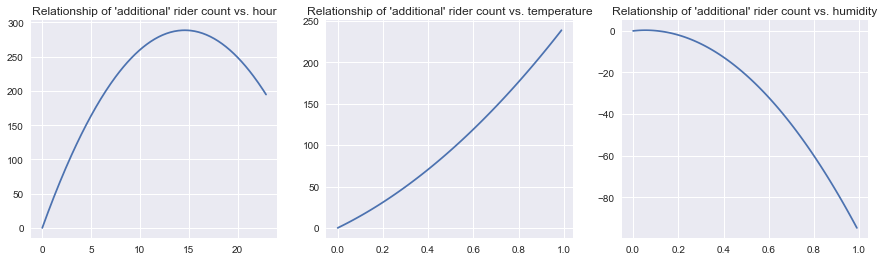

In [62]:
hour_coef = poly_model.params[['hour','hour2']]
temp_coef = poly_model.params[['temp','temp2']]
hum_coef = poly_model.params[['hum','hum2']]

# just a sanity check.  hour should be between 0 and 23, and temp and hum should 
# be between 0 and 1 (they are normalized).  This is needed for graphing the relationships
print((np.min(X_train['hour']),np.max(X_train['hour'])))
print((np.min(X_train['temp']),np.max(X_train['temp'])))
print((np.min(X_train['hum']),np.max(X_train['hum'])))

x_hour = np.arange(0,23,0.1)
x_temp = x_hum = np.arange(0,1,0.01)

fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].plot(x_hour,hour_coef[0]*x_hour+hour_coef[1]*(x_hour**2))
axs[0].set_title("Relationship of 'additional' rider count vs. hour")
axs[1].plot(x_temp,temp_coef[0]*x_temp+temp_coef[1]*(x_temp**2))
axs[1].set_title("Relationship of 'additional' rider count vs. temperature")
axs[2].plot(x_hum,hum_coef[0]*x_hum+hum_coef[1]*(x_hum**2))
axs[2].set_title("Relationship of 'additional' rider count vs. humidity")

Hour: Rides clearly increase and then decrease as the day goes on, matching the pattern we saw in the original plots: peak ridership around 8am and 5pm, and lower rental counts later on.

These plots show the general relationships based on the coefficients of the polynomial regression model (Note: the y-axis is not very interpretable, other than it represents the 'marginal' effect over what the rest of the predictors provide, but the relationships hold up).  We see that ridership is predicted to peak at about 3pm, ridership is predicted to increase and accelerate slightly as temperature increases, and ridership is predicted to peak at a low level, and then decrease (as humidity increases).  All of these relationships are holding the other predictors in the model constant (which is tough to do, especially with temp and temp).

#### **4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?

In [38]:
# your code here
X_train_drop = X_train.drop(['workingday','atemp','spring','summer','fall'], axis=1)
OLS(y_train, X_train_drop).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     358.3
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        21:31:00   Log-Likelihood:                -88363.
No. Observations:               13903   AIC:                         1.768e+05
Df Residuals:                   13876   BIC:                         1.770e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.0627      8.541     -2.349      0.019     -36.805      -3.321
hour           7.2378      0.185     39.095      0.000       6.875       7.601
holiday      -35.8906      7.395     -4.854      0.000     -50.385     -21.396
year          76.3039      2.389     31.945      0.000      71.622      80.986
temp         406.2359     13.279     30.593      0.000     380.208     432.264
hum         -201.5103      7.800    -25.835      0.000    -216.799    -186.221
windspeed     11.9668     10.448      1.145      0.252      -8.512      32.446
Feb           -7.6897      5.986     -1.285      0.199     -19.422       4.043
Mar            2.8889      6.158      0.469      0.639      -9.182      14.960
Apr            1.0237      6.594      0.155      0.877     -11.902      13.950
May            7.2426      7.613      0.951      0.341      -7.680      22.165
Jun          -30.6611      8.346     -3.674      0.000     -47.020     -14.302
Jul          -67.7620      9.062     -7.477      0.000     -85.525     -49.999
Aug          -34.2712      8.628     -3.972      0.000     -51.183     -17.359
Sept          20.6406      7.882      2.619      0.009       5.191      36.090
Oct           50.7025      6.823      7.431      0.000      37.329      64.076
Nov           42.3211      6.111      6.926      0.000      30.344      54.299
Dec           34.2134      5.952      5.748      0.000      22.546      45.881
Mon            9.2907      4.570      2.033      0.042       0.333      18.248
Tue            4.7929      4.442      1.079      0.281      -3.914      13.500
Wed           13.2143      4.417      2.992      0.003       4.557      21.871
Thu            8.0051      4.445      1.801      0.072      -0.708      16.718
Fri           13.0474      4.429      2.946      0.003       4.367      21.728
Sat           14.1461      4.397      3.217      0.001       5.528      22.764
Cloudy         6.7192      2.909      2.310      0.021       1.018      12.421
Snow         -29.1668      4.828     -6.041      0.000     -38.631     -19.703
Storm         40.3125     98.759      0.408      0.683    -153.267     233.893
==============================================================================
Omnibus:                     2850.389   Durbin-Watson:                   0.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5702.134
Skew:                           1.231   Prob(JB):                         0.00
Kurtosis:                       4.944   Cond. No.                     1.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
""

*your answer here*

Yes, many of the coefficients seem a little more sensible.  For example July's effect is now less negative (-67 vs. -93 before).  But many seem to be in an anti-intuitive direction (more riders during storms, fewer riders in the warmer months, etc.), and this is due to all the remaining collinearity between month, temp, hum, and weather.

<div class='exercise'><b> Question 5 [20pts]: Subset Selection </b> </div>
Perhaps we can automate finding a good set of predictors. This question focuses on forward stepwise selection, where predictors are added to the model one by one.

**5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

<i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

**5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

### Answers

#### **5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

#### We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

#### <i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

In [39]:
# your code here
def step_forwards_backwards(df, y, direction='forward'):
    
    assert direction in ['forward', 'backward']

    predictors = set(df.columns)
    selected_predictors = set() if direction=='forward' else set(predictors)
    
    n = df.shape[0]
    best_bic = np.inf
    
    best_bics = []
    best_models = []
    
    if direction == 'forward':
        X = np.ones(n).reshape(-1,1)
        X = np.concatenate([X, df[list(selected_predictors)].values], axis=1)
        while (True):
            
            possible_bic_scores = []
            possible_predictors = list(selected_predictors ^ predictors)
            
            if len(possible_predictors) == 0:
                break
                
            for predictor in possible_predictors:
                
                x_temp = np.concatenate([X, df[predictor].values.reshape(-1,1)], axis=1)
                model = OLS(endog=y, exog=x_temp).fit()
                bic = model.bic
                possible_bic_scores.append(bic)
                
            best_predictor_ix = np.argmin(possible_bic_scores)
            best_predictor = possible_predictors[best_predictor_ix]
            
            best_bic = np.min(possible_bic_scores)
            best_bics.append(best_bic)
            
            selected_predictors.add(best_predictor)            
            X = np.concatenate([X, df[best_predictor].values.reshape(-1,1)], axis=1)
            best_models.append(list(selected_predictors))

    else:

        while (True):
            possible_bic_scores = []
            possible_predictors = list(selected_predictors)

            if len(possible_predictors) == 0:
                break

            for predictor in possible_predictors:
                X = np.concatenate([np.ones(n).reshape(-1,1), 
                                    df[list(selected_predictors - set([predictor]))].values], axis=1)
                model = OLS(endog=y, exog=X).fit()
                bic = model.bic
                possible_bic_scores.append(bic)

            best_predictor_ix = np.argmin(possible_bic_scores)
            best_predictor = possible_predictors[best_predictor_ix] 

            best_bic = possible_bic_scores[best_predictor_ix]
            selected_predictors.discard(best_predictor)
            
            best_bics.append(best_bic)
            best_models.append(list(selected_predictors))
            
    index_of_best_bic = np.argmin(best_bics)

    return best_models[index_of_best_bic]

In [40]:
# your code here
predictors_forward = step_forwards_backwards(X_train_poly, y_train, direction='forward')
predictors_forward

['year',
 'Jul',
 'fall',
 'Cloudy',
 'hum2',
 'hour',
 'spring',
 'Sept',
 'holiday',
 'temp',
 'Snow',
 'hour2']

OR

In [41]:
# your code here
predictors_backward = step_forwards_backwards(X_train_poly, y_train, direction='backward')
predictors_backward

['Sat',
 'hum2',
 'Jun',
 'Jul',
 'hour',
 'temp',
 'Snow',
 'year',
 'fall',
 'summer',
 'Cloudy',
 'spring',
 'Aug',
 'workingday',
 'Nov',
 'hour2']

#### **5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

*your answer here*

Yes, forward selection drops quite a few predictors, including `atemp`, most of the month/season dummies, and all of the weekday/workingday dummies. It seems that these terms can compete once holiday, temp, and other features are included early in the process.

#### **5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

In [42]:
# your code here
X_forward = X_train_poly[predictors_forward]
X_forward_test = X_test_poly[predictors_forward]

model = OLS(endog=y_train, exog=X_forward)
result = model.fit()

y_hat_train = result.predict()
y_hat_test = result.predict(exog=X_forward_test)

print('train r2 = {:.4}'.format( r2_score(y_train, y_hat_train)))
print('test r2 = {:.4}'.format(r2_score(y_test, y_hat_test)))

train r2 = 0.4516
test r2 = 0.4458


*your answer here*

In the original polynomial model, our $R^2$ was about .496 on both the training and test sets.  With the forward-selected features, our $R^2$ values are diminished by about .05.  We've paid a bit of a price for simplicity, and it may be that BIC was not accurately predicting the model's out of sample performance.

<HR>

#  Written Report to the Administrators [20 pts]
<br>

<div class='exercise'> <b> Question 6 [20pts] </b> </div>

Write a short repost stating some of your findings on how the administrators can increase the bike share system's revenue. You might want to include suggestions such as what model to use to predict ridership, what additional services to provide, or when to give discounts, etc. 
Include your report as a pdf file in canvas. The report should not be longer than one page (300 words) and should include a maximum of 5 figures. 

#### Answers 6




*your answer here*

Looking at the linear regression models, temperature, weather severity, humidity, and time of day appear to be the driving forces in modeling counts.  Some facsimile of this presents itself when we do a full regression, the step forward regression, or step backward regression.

### You might want to include suggestions such as what model to use to predict ridership:

All of the models we calculated run about the same in terms of $R^2$.  For the best result, using the polymodel with up to quadratic terms gives the best regression.  There is no reason to assume that the continuous variables should have a strictly linear effect, particularly as hour of the day should have positive impact at the middle of the day, and negative impact at the ends of the day (this was borne out by the regression and statistically significant variables).  Consequently, we opt for the polynomial model.

### What additional services to provide:

Noting that ridership is diminished in the winter, in a statistically siginificant way, heated seats or handlebar mounted gloves might help casual riders overcome the cold, particularly on days that are cold, but otherwise good weather.

### When to give discounts:

In the winter when the temperature is low, discounts may help increase ridership, but in the warmer months, there is greater variance to ridership, and a higher mean ridership.  Offering a discount on a high humidity day may exploit the inherently higher variance and mean to give a more significant boost in ridership.

### Worth further exploration:

Predicting registered or casual counts separately: the two features function in very distinct ways, and trying to predict their relative counts without intermingling allows for much greater correlation with fewer variables.

<HR>



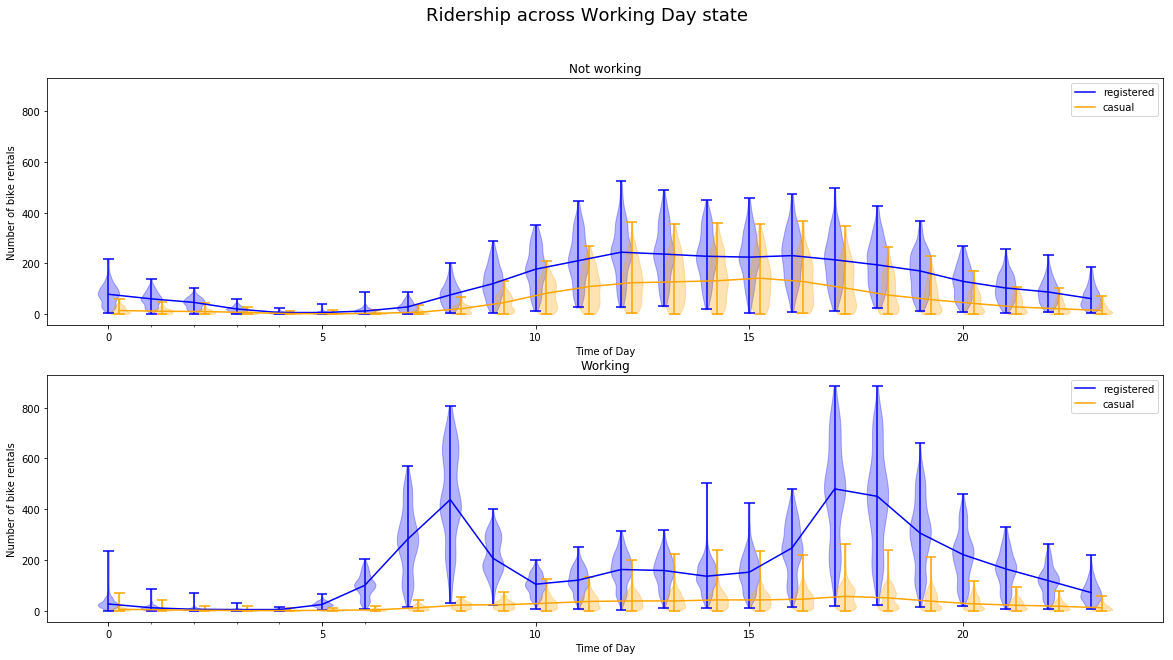

In [43]:
# your code here
fig, ax = plt.subplots(2,1, figsize=(20,10), sharey=True)
ax = ax.ravel()

working_strings = ["Not working","Working"]
for working in [0,1]:
    cur_ax = ax[working]
    cur_working_string = working_strings[working]

    bikes_df_working = bikes_df[((bikes_df.workingday == working) & (bikes_df.holiday != 1))]


    reg_hourly_data,cas_hourly_data = get_violin_lists(bikes_df_working, 'hour')
    reg = cur_ax.violinplot(dataset=reg_hourly_data, positions=np.arange(24))
    cas = cur_ax.violinplot(dataset=cas_hourly_data, positions=np.arange(24)+.25)
    
    color_violin(reg, reg_color)
    color_violin(cas, casual_color)

    reg_hourly_data_median= [np.median(q) for q in reg_hourly_data]
    cas_hourly_data_median= [np.median(q) for q in cas_hourly_data]

    cur_ax.plot(reg_hourly_data_median, reg_color, label="registered")
    cur_ax.plot(np.arange(24)+.25,cas_hourly_data_median, casual_color, label="casual")
    
    cur_ax.legend()

    cur_ax.set_xticks(list(days_tick_dict.keys()), list(days_tick_dict.values()))
    cur_ax.set_ylabel('Number of bike rentals')
    cur_ax.set_xlabel('Time of Day')
    cur_ax.set_title(working_strings[working])

plt.suptitle("Ridership across Working Day state",fontsize = 18)
plt.show()

*your answer here* 

The working day counts for registered riders appears bimodal.  This seems to contribute to a high mean and high variance for registered riders during the working week.  Given that registered rider count is high and registered ridership on working days is also high variance, sporadic discounts on working days to try to select for the higher mode may be particularly effective for boosting business.

<HR>

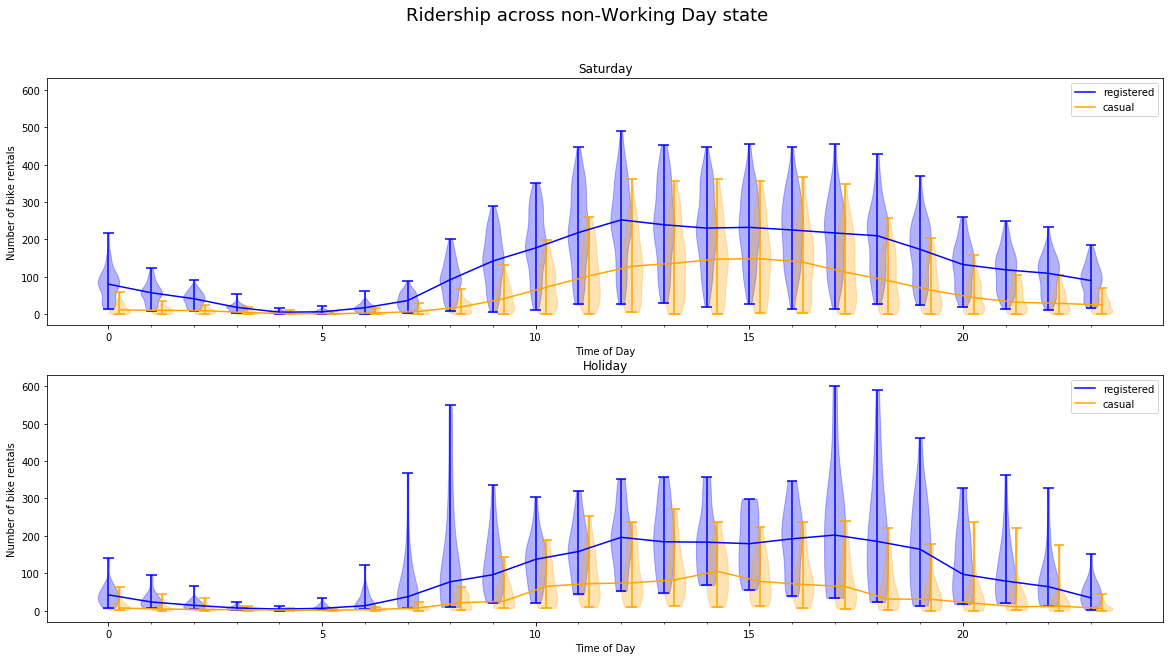

In [44]:
#your code here
fig, ax = plt.subplots(2,1, figsize=(20,10), sharey=True)
ax = ax.ravel()

# Saturday data
cur_ax = ax[0]

bikes_df_sub = bikes_df[((bikes_df.Sat == 1))]

reg_hourly_data,cas_hourly_data = get_violin_lists(bikes_df_sub, 'hour')
reg = cur_ax.violinplot(dataset=reg_hourly_data, positions=np.arange(24))
cas = cur_ax.violinplot(dataset=cas_hourly_data, positions=np.arange(24)+.25)

color_violin(reg, reg_color)
color_violin(cas, casual_color)

reg_hourly_data_median= [np.median(q) for q in reg_hourly_data]
cas_hourly_data_median= [np.median(q) for q in cas_hourly_data]

cur_ax.plot(reg_hourly_data_median, reg_color, label="registered")
cur_ax.plot(np.arange(24)+.25,cas_hourly_data_median, casual_color, label="casual")

cur_ax.legend()

cur_ax.set_xticks(list(hours_tick_dict.keys()), list(hours_tick_dict.values()))
cur_ax.set_ylabel('Number of bike rentals')
cur_ax.set_xlabel('Time of Day')
cur_ax.set_title("Saturday")


# Holiday data
cur_ax = ax[1]

bikes_df_sub = bikes_df[((bikes_df.holiday == 1))]

reg_hourly_data,cas_hourly_data = get_violin_lists(bikes_df_sub, 'hour')
reg = cur_ax.violinplot(dataset=reg_hourly_data, positions=np.arange(24),)
cas = cur_ax.violinplot(dataset=cas_hourly_data, positions=np.arange(24)+.25)

color_violin(reg, reg_color)
color_violin(cas, casual_color)

reg_hourly_data_median= [np.median(q) for q in reg_hourly_data]
cas_hourly_data_median= [np.median(q) for q in cas_hourly_data]

cur_ax.plot(reg_hourly_data_median, reg_color, label="registered")
cur_ax.plot(np.arange(24)+.25,cas_hourly_data_median, casual_color, label="casual")

cur_ax.legend()

cur_ax.set_xticks(list(hours_tick_dict.keys()), list(hours_tick_dict.values()))
cur_ax.set_ylabel('Number of bike rentals')
cur_ax.set_xlabel('Time of Day')
cur_ax.set_title("Holiday")

plt.suptitle("Ridership across non-Working Day state",fontsize = 18)
plt.show()

*your answer here* 

On weekends, registered riders appear to function similarly to casual riders, but on holidays, registered riders appear to function differently than their casual counterparts.  They appear to reduce in numbers, but follow distributions as if it was a working day with errands and chores.  A possible discount on holidays might keep the registered numbers from taking a full day off and not renting a bike
<HR>